<a href="https://colab.research.google.com/github/sikha2552/CNN_Evolution_UPC/blob/main/UMAP_Evolution_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To read:

https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570347731.pdf

https://openaccess.thecvf.com/content/ICCV2021W/CVPPA/papers/Mostafa_Visualizing_Feature_Maps_for_Model_Selection_in_Convolutional_Neural_Networks_ICCVW_2021_paper.pdf

https://arxiv.org/pdf/2007.07477.pdf

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7536654&casa_token=8W4QZla53MkAAAAA:zLF7dFyjmKhlsvfwhm0Bmz7mEFIZIEpazFZsoNwhH7U_p0iuz51VUrJjEhV8asg1tQrTAMwM9zPSDA&tag=1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/')

In [2]:
from skimage import data, measure
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers
import explainabilityModels
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Load MNIST dataset**

In [3]:
import numpy as np
from tensorflow import keras

In [4]:
# Set a fixed random seed value
np.random.seed(42)
#Load the dataset and split into train and test
(x_train,y_train),(x_test,y_test)=keras.datasets.mnist.load_data()
#Normalize the data
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0
print(f"Size of training samples {x_train.shape}")
print(f"Size of testing samples {x_test.shape}")

Size of training samples (60000, 28, 28)
Size of testing samples (10000, 28, 28)


In [5]:
from sklearn.model_selection import train_test_split
#Convert the data into a 4 dimensional tensor
x_train=np.expand_dims(x_train,axis=-1)
x_test=np.expand_dims(x_test,axis=-1)
print(f"Size of training samples {x_train.shape}")
print(f"Size of testing samples {x_test.shape}")
# Fix the train and test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


Size of training samples (60000, 28, 28, 1)
Size of testing samples (10000, 28, 28, 1)


##**Display Sample Images**

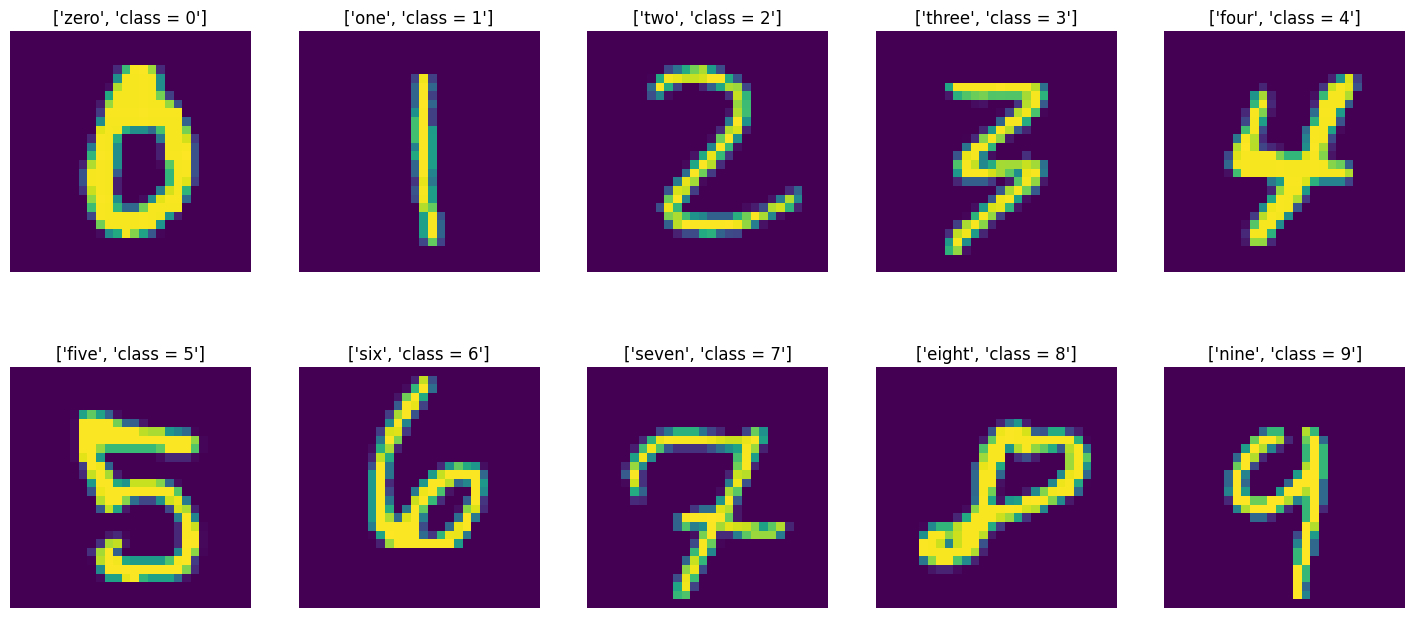

In [6]:
import skimage as sk
from skimage import io
import matplotlib.pyplot as plt
label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

fig = plt.figure(figsize=(18, 8))

for k in range(0,10):
    ind = np.argwhere(y_train==k)
    ax = fig.add_subplot(2, 5, k+1)
    ax.imshow(x_train[ind[0][0]].squeeze())
    ax.set_title([label_names[k], 'class = {}'.format(k)])
    ax.axis('off')

In [7]:
# Model hyperparameters
num_classes = 10
size=x_train[1].shape[0]
input_shape = (size, size, 1)
batch_size = 64
epochs = 20
conv_size=(3,3)
save = False #if running the entire notebook, always set this to false! otherwise you might overwrite something if you forget to change the name of the file
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

## **The Custom model**


In [8]:
#create model
#the model is a standard three layer CNN architecture. If this happens to not work on your dataset, some useful things might include:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(2, kernel_size=conv_size, activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2),name='feature1'),
        layers.Conv2D(4, kernel_size=conv_size, activation="relu", padding='same',name='Conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="feature2"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 2)         20        
                                                                 
 feature1 (MaxPooling2D)     (None, 14, 14, 2)         0         
                                                                 
 Conv2 (Conv2D)              (None, 14, 14, 4)         76        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 4)          0         
 )                                                               
                                                                 
 feature2 (Flatten)          (None, 196)               0         
                                                                 
 dense (Dense)               (None, 10)                1970      
                                                        

In [9]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
histoty=model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/20
760/760 [==============================] - 39s 49ms/step - loss: 0.6864 - accuracy: 0.7966 - val_loss: 0.2939 - val_accuracy: 0.9111
Epoch 2/20
760/760 [==============================] - 28s 37ms/step - loss: 0.2599 - accuracy: 0.9215 - val_loss: 0.2003 - val_accuracy: 0.9430
Epoch 3/20
760/760 [==============================] - 18s 24ms/step - loss: 0.2045 - accuracy: 0.9384 - val_loss: 0.1639 - val_accuracy: 0.9537
Epoch 4/20
760/760 [==============================] - 17s 23ms/step - loss: 0.1759 - accuracy: 0.9480 - val_loss: 0.1525 - val_accuracy: 0.9561
Epoch 5/20
760/760 [==============================] - 18s 23ms/step - loss: 0.1590 - accuracy: 0.9521 - val_loss: 0.1464 - val_accuracy: 0.9565
Epoch 6/20
760/760 [==============================] - 18s 23ms/step - loss: 0.1485 - accuracy: 0.9557 - val_loss: 0.1252 - val_accuracy: 0.9620
Epoch 7/20
760/760 [==============================] - 20s 27ms/step - loss: 0.1395 - accuracy: 0.9583 - val_loss: 0.1207 - val_accuracy:

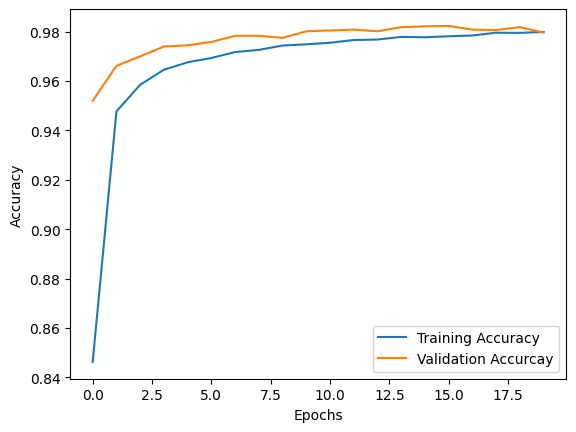

In [ ]:
#plot the training and validation accuracy curve
plt.plot(histoty.history['accuracy'])
plt.plot(histoty.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel ("Accuracy")
plt.legend(["Training Accuracy","Validation Accurcay"],loc='lower right')

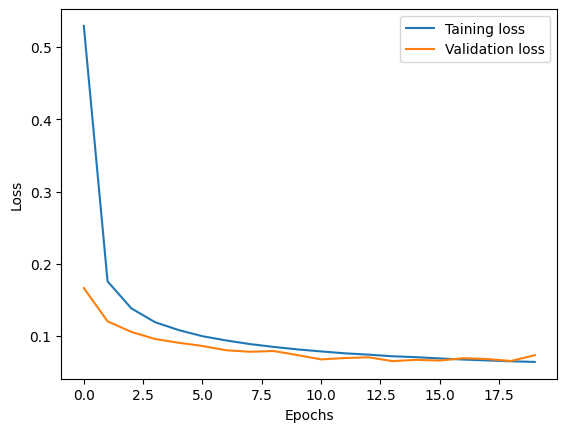

In [ ]:
#Plot the training and validation loss
plt.plot(histoty.history['loss'])
plt.plot(histoty.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Taining loss','Validation loss'],loc='upper right')

In [ ]:
#Save Model
model.save('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/model_epoch1_val_40.9945.h5')

## **Model evaluation**



In [ ]:
model.load_weights('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/model_epoch1_val_40.9945.h5')

In [ ]:
np.argmax(model.predict(x_test),axis=1)

313/313 [==============================] - 2s 5ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.08181112259626389
Test accuracy: 0.974399983882904
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        zero       0.97      0.99      0.98       980
         one       0.97      1.00      0.98      1135
         two       0.98      0.94      0.96      1032
       three       0.96      0.99      0.98      1010
        four       0.97      0.99      0.98       982
        five       0.98      0.97      0.98       892
         six       0.99      0.98      0.98       958
       seven       0.98      0.97      0.98      1028
       eight       0.97      0.95      0.96       974
        nine       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)
label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1), ('also healthy', 2)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


In [ ]:
#show image
img = x_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
label = pred_picker.value
plt.imshow(img)

In [ ]:
#Load images to visualize the gradcam
img=x_test[1]

In [ ]:
#generate heatmap with keras implmentation of gradcam
heatmap = explainabilityModels.make_gradcam_heatmap(img, model)

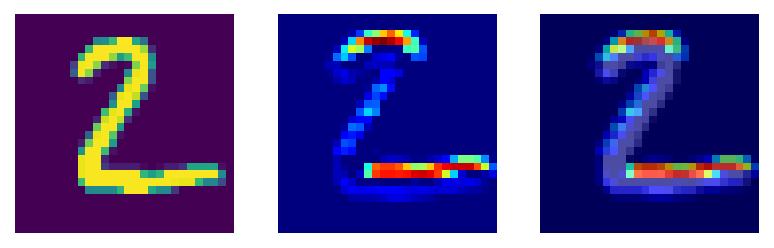

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_dpi(150)
fig.tight_layout

ax[0].imshow(img)
ax[1].imshow(heatmap, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray')
ax[2].imshow(heatmap, alpha = 0.7, cmap='jet')

for a in ax:
  a.axis('off')


### **Define the model for feature extraction**

In [ ]:

from tensorflow.keras.models import Model

#base_model = keras.models.load_model(folder_data + '/model_saved')

model_FE = Model(inputs=model.input, outputs=model.get_layer('features').output)
model_FE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 4)          0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 196)               0   

In [ ]:
df_train = model_FE.predict(x_train) # extract Deep trained features from text subset

1875/1875 [==============================] - 3s 2ms/step


In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 # Obtain the features for your data
features = model_FE.predict(x_train)
# Perform UMAP dimensionality reduction
umap_emb = umap.UMAP().fit_transform(features)
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
#filename = f'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs/scatter_plot_epoch_{epochs}.png'
plt.savefig( f'/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist{epochs}.png', dpi=300)

##**Train the model and save weights in each epoch , Visualize Umap in each epoch**

In [13]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
# Create a new model with the features layer as the output
features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)

# Define a list to store UMAP visualizations
umap_plots = []

# Define the number of epochs
num_epochs =20
# Create a directory to store the weights and UMAP visualizations
weights_dir = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Weight_epoch'
Umap_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Umap_epoch'
os.makedirs(weights_dir, exist_ok=True)
for epoch in range(num_epochs):

    # Define the checkpoint filepath for the current epoch
    checkpoint_filepath = os.path.join(
        weights_dir, f'weights_{epoch + 1:02d}.h5')
    # Define the ModelCheckpoint callback for the current epoch
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        save_best_only=False,
        save_freq='epoch'
    )
    # Train your model for one epoch
    history=model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=1, validation_split=0.1,callbacks=[checkpoint_callback])
    # Obtain the features for your data
    features = features_model.predict(x_train)

    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)

    # Plot the UMAP visualization
    plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=np.argmax(y_train_cat, axis=1))
    #plt.colorbar()
    plt.axis('off')
    plt.title(f"UMAP Visualization - Epoch {epoch+1}")

    # Save the UMAP visualization
    umap_plot_filepath =  os.path.join(
        Umap_dir,  f"umap_visualization_epoch_{epoch+1}.png")
    plt.savefig(umap_plot_filepath)
    # Clear the plot for the next epoch
    plt.clf()
    # Append the UMAP visualization filepath to the list
    umap_plots.append(umap_plot_filepath)
    #Plot using sns
    sns_plot_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Umap_epoch/sna_plots'
    sns.scatterplot(x = umap_emb[:, 0], y = umap_emb[:, 1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
    sns_plot_filepath =  os.path.join(
        sns_plot_dir,  f"umap_visualization_epoch_{epoch+1}.png")
    plt.savefig(sns_plot_filepath)
    plt.savefig(  sns_plot_filepath, dpi=300)
    # Clear the plot for the next epoch
    plt.clf()

# Print the list of UMAP visualization filepaths
print("UMAP Visualizations:")
for umap_plot_filepath in umap_plots:
    print(umap_plot_filepath)

## Save UMAP Embedding for each layer for each each epoch first Convolutional Layer

In [15]:
import umap
import os
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Weight_epoch'
Umap_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/Umap_epoch'
UMAP_EMDB=[]
# Define a list to store UMAP visualizations
umap_plots = []
i=1

for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)

   # Create a new model with the first convolutional layers as the output
    conv_model = keras.Model(inputs=model.input, outputs=model.get_layer("feature1").output)
    convout = conv_model.predict(x_train)
    features=convout.reshape(convout.shape[0], -1)

   # Create a new model with the second convolutional layers as the output
    #features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    #features = features_model.predict(x_train)

    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    UMAP_EMDB.append(umap_emb)
    # Plot the UMAP visualization
    plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=np.argmax(y_train_cat, axis=1))
    #plt.colorbar()
    plt.axis('off')
    plt.title(f"UMAP Visualization - Epoch {i}")

    # Save the UMAP visualization
    umap_plot_filepath =  os.path.join(
        Umap_dir,  f"umap_visualization_epoch_{i}.png")
    plt.savefig(umap_plot_filepath)
    # Clear the plot for the next epoch
    plt.clf()
    # Append the UMAP visualization filepath to the list
    umap_plots.append(umap_plot_filepath)
    #Plot using sns
    sns_plot_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/Umap_epoch/sns_plots'
    sns.scatterplot(x = umap_emb[:, 0], y = umap_emb[:, 1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
    sns_plot_filepath =  os.path.join(
        sns_plot_dir,  f"umap_visualization_epoch_{i}.png")
    plt.savefig(sns_plot_filepath)
    plt.savefig(  sns_plot_filepath, dpi=300)
    # Clear the plot for the next epoch
    plt.clf()
    i=i+1

# Convert the UMAP embeddings to a 2-dimensional format
output_file= '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/UMAP_Final_withlabels_Conv1.xlsx'
umap_embeddings=UMAP_EMDB
# Determine the maximum number of data points across all epochs
max_length = max(len(umap_emb) for umap_emb in umap_embeddings)

# Create a dictionary to store the UMAP embeddings for each dimension
umap_data = {}

# Add two columns for each epoch output
for i, umap_emb in enumerate(umap_embeddings):
    # Pad the UMAP embeddings with NaN values if necessary
    umap_emb_padded = np.pad(umap_emb, ((0, max_length - len(umap_emb)), (0, 0)), mode='constant', constant_values=np.nan)

    umap_data[f'UMAP Dimension 1 - Epoch {i+1}'] = umap_emb_padded[:, 0]
    umap_data[f'UMAP Dimension 2 - Epoch {i+1}'] = umap_emb_padded[:, 1]
# Convert y_train to floating-point type before padding
y_train_float = y_train.astype(float)
# Append the labels to the umap_data dictionary
umap_data['Labels'] = np.pad(y_train_float, (0, max_length - len(y_train_float)), mode='constant', constant_values=np.nan)
# Create a DataFrame from the dictionary
umap_df = pd.DataFrame(umap_data)

# Save the UMAP embeddings to an Excel file
umap_df.to_excel(output_file, index=False)

1519/1519 [==============================] - 10s 6ms/step


<Figure size 640x480 with 0 Axes>

## **Clustering analysis to quantify the quality of featuremap embeddings**

In [17]:
import umap
import os
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras.models import Model
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Weight_epoch'

# Assuming you have your data stored in a variable called `X`
i=1
sil=[]
dbi_values=[]
intra_class_distances = []
inter_class_distances = []
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    #features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    #features = features_model.predict(x_train)

     # Create a new model with the first convolutional layers as the output
    conv_model = keras.Model(inputs=model.input, outputs=model.get_layer("feature1").output)
    convout = conv_model.predict(x_train)
    features=convout.reshape(convout.shape[0], -1)

    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
# Calculate the Silhouette Score
    silhouette_avg = silhouette_score(umap_emb,y_train)
    sil.append( silhouette_avg)
    print(f"Silhouette Score Epoch {i}: {silhouette_avg}")
     # Calculate the Davies-Bouldin Index: Lower the values Better the clustering
    dbi= davies_bouldin_score(umap_emb,y_train)
    dbi_values.append(dbi)
    print(f"DBI Epoch {i}: {dbi}")
    labels = y_train
    unique_classes = np.unique(labels)
    i=i+1
     # Calculate intra-class distances
    embeddings=umap_emb
    intra_distances = []
    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]
        class_embeddings = embeddings[class_indices]
        intra_distance = np.mean(euclidean_distances(class_embeddings))
        intra_distances.append(intra_distance)
    intra_class_distances.append(np.mean(intra_distances))

    # Calculate inter-class distances
    inter_distances = []
    for i in range(len(unique_classes)):
        for j in range(i + 1, len(unique_classes)):
            class_i_indices = np.where(labels == unique_classes[i])[0]
            class_j_indices = np.where(labels == unique_classes[j])[0]
            class_i_embeddings = embeddings[class_i_indices]
            class_j_embeddings = embeddings[class_j_indices]
            inter_distance = np.mean(euclidean_distances(class_i_embeddings, class_j_embeddings))
            inter_distances.append(inter_distance)
    inter_class_distances.append(np.mean(inter_distances))
    # Save the Silhouette values to an Excel file
sil_df = pd.DataFrame({'Epoch': range( 20), 'Silhouette':sil})
sil_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/Silhouette_values.xlsx', index=False)
 # Save the DBI values to an Excel file
dbi_df = pd.DataFrame({'Epoch': range(1, len(dbi_values) + 1), 'DBI': dbi_values})
dbi_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/dbi_values.xlsx', index=False)

#Save interclass and intrclass distances
# Print the intra-class and inter-class distances for each epoch
for epoch in range(20):
    print(f"Epoch {epoch+1}: Intra-class distance = {intra_class_distances[epoch]}, Inter-class distance = {inter_class_distances[epoch]}")

    # Save the DBI values to an Excel file
dbi_cl = pd.DataFrame({'Epoch': range(20), 'Intra-class distance': intra_class_distances,'Inter-class distance':inter_class_distances})
dbi_cl.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/Simple_ModelClass_distances.xlsx', index=False)

1519/1519 [==============================] - 11s 8ms/step
Silhouette Score Epoch 1: 0.5514313578605652
DBI Epoch 1: 0.6877356254501006
1519/1519 [==============================] - 9s 6ms/step
Silhouette Score Epoch 9: 0.5301567316055298
DBI Epoch 9: 0.7364320815102463
1519/1519 [==============================] - 10s 6ms/step
Silhouette Score Epoch 9: 0.5581056475639343
DBI Epoch 9: 0.6683350841765187
1519/1519 [==============================] - 9s 6ms/step
Silhouette Score Epoch 9: 0.5548226237297058
DBI Epoch 9: 0.6792892596994292
1519/1519 [==============================] - 8s 6ms/step
Silhouette Score Epoch 9: 0.5408468246459961
DBI Epoch 9: 0.7129751015873504
1519/1519 [==============================] - 8s 5ms/step
Silhouette Score Epoch 9: 0.5588520169258118
DBI Epoch 9: 0.6642476677625669
1519/1519 [==============================] - 7s 4ms/step
Silhouette Score Epoch 9: 0.5593562722206116
DBI Epoch 9: 0.6666384443963294
1519/1519 [==============================] - 7s 4ms/step
Sil

## **Umap Embedding for DMD Analysis**

## Save the Umap Embeddings

In [ ]:
import umap
import os
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/Weight_epoch'
UMAP_EMDB=[]
i=1

for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)

   # Create a new model with the convolutional layers as the output
    conv_model = keras.Model(inputs=model.input, outputs=model.get_layer("Conv1").output)
    convout = conv_model.predict(x_train)
    features=convout.reshape(convout.shape[0], -1)

    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP().fit_transform(features)
    UMAP_EMDB.append(umap_emb)
#umap_df = pd.DataFrame(UMAP_EMDB)
#umap_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/umap_embedding.xlsx', index=False)

1688/1688 [==============================] - 2s 1ms/step


In [ ]:

# Convert the UMAP embeddings to a 2-dimensional format
output_file= '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/CONV1_results/UMAP_Final_withlabels_14thjune_t2.xlsx'
umap_embeddings=UMAP_EMDB
# Determine the maximum number of data points across all epochs
max_length = max(len(umap_emb) for umap_emb in umap_embeddings)

# Create a dictionary to store the UMAP embeddings for each dimension
umap_data = {}

# Add two columns for each epoch output
for i, umap_emb in enumerate(umap_embeddings):
    # Pad the UMAP embeddings with NaN values if necessary
    umap_emb_padded = np.pad(umap_emb, ((0, max_length - len(umap_emb)), (0, 0)), mode='constant', constant_values=np.nan)

    umap_data[f'UMAP Dimension 1 - Epoch {i+1}'] = umap_emb_padded[:, 0]
    umap_data[f'UMAP Dimension 2 - Epoch {i+1}'] = umap_emb_padded[:, 1]
# Convert y_train to floating-point type before padding
y_train_float = y_train.astype(float)
# Append the labels to the umap_data dictionary
umap_data['Labels'] = np.pad(y_train_float, (0, max_length - len(y_train_float)), mode='constant', constant_values=np.nan)
# Create a DataFrame from the dictionary
umap_df = pd.DataFrame(umap_data)

# Save the UMAP embeddings to an Excel file
umap_df.to_excel(output_file, index=False)

In [ ]:
#Store the Umap embeddings June 14
import umap
import os
import matplotlib.pyplot as plt
import seaborn as sns
output_folder = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Simple_Model/UMAP_Plots_June14/sns'
os.makedirs(output_folder, exist_ok=True)

for i, umap_emb in enumerate(umap_embeddings):
    # Plot and save the UMAP embeddings
    fig = plt.figure(figsize=(8, 6))
    sns.scatterplot(x = umap_emb[:, 0], y = umap_emb[:, 1], hue=y_train, palette = sns.hls_palette(10), legend = 'full');
    plt.savefig(os.path.join(output_folder, f"UMAP_Plot_{i+1}.png"))
    plt.close(fig)

## **Calculate the L2 norm of UMap Embeddings and store them**

In [ ]:
# Convert the UMAP embeddings to a 2-dimensional format
output_file_rss= '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/rss.xlsx'
# Create a list to store the root of sum of squares for each epoch
rss_values = []
umap_embeddings=UMAP_EMDB
# Create an empty array to store the RSS values
rss_values = np.zeros((len(umap_embeddings[0]), len(umap_embeddings)))

# Calculate the RSS for each row of embeddings
for i, umap_emb in enumerate(umap_embeddings):
    rss = np.sqrt(np.sum(umap_emb**2, axis=1))
    rss_values[:, i] = rss
# Create a dictionary to store the UMAP embeddings and RSS values
umap_data = {}
for i, umap_emb in enumerate(umap_embeddings):
    #umap_data[f'UMAP Dimension 1 - Epoch {i+1}'] = umap_emb[:, 0]
    #umap_data[f'UMAP Dimension 2 - Epoch {i+1}'] = umap_emb[:, 1]
    umap_data[f'RSS - Epoch {i+1}'] = rss_values[i]

# Append the labels to the umap_data dictionary
#umap_data['Labels'] = y_train

# Create a DataFrame from the dictionary
umap_df = pd.DataFrame(umap_data)

# Save the DataFrame to an Excel file
output_file = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/umap_rss_labels.xlsx'
umap_df.to_excel(output_file, index=False)

### **Umap Embedding 1 Dimensional for DMD Analysis**

In [ ]:
import os
import umap
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
weights_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/Weight_epoch'
UMAP_EMDB1D=[]
labels_list = []

i=1
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
  # Create a new model with the features layer as the output
    features_model = keras.Model(inputs=model.input, outputs=model.get_layer("features").output)
    features = features_model.predict(x_train)

    # Perform UMAP dimensionality reduction
    umap_emb = umap.UMAP(n_components=1).fit_transform(features)
    UMAP_EMDB1D.append(umap_emb)
    # Get the labels for the current epoch
    labels = y_train[i]
    labels_list.append(labels)

    i=i+1
# Convert the UMAP embeddings and labels to NumPy arrays
umap_emb1d = np.array( UMAP_EMDB1D)
labels_list = np.array(labels_list)

# Create a DataFrame with UMAP embeddings and labels as columns
umap_df = pd.DataFrame(umap_emb1d)
#umap_df['Labels'] = labels_list

# Save the DataFrame to an Excel file
output_path = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/UMAP_EMDB1D_mnist_new.xlsx'
umap_df.to_excel(output_path, index=False)

In [ ]:
# Convert y_train to floating-point type before padding
y_train_float = y_train.astype(float)
# Append the labels to the umap_data dictionary
umap_data['Labels'] = np.pad(y_train_float, (0, max_length - len(y_train_float)), mode='constant', constant_values=np.nan)
# Create a DataFrame from the dictionary
umap_df = pd.DataFrame(umap_data)

In [ ]:
# Convert y_train to floating-point type before padding
y_train_float = y_train.astype(float)
# Append the labels to the umap_data dictionary

umap1d_df['Labels'] = np.pad(y_train_float, (0, max_length - len(y_train_float)), mode='constant', constant_values=np.nan)
# Create a DataFrame from the dictionary
# Save the DataFrame to an Excel file
umap1d_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/UMAP_EMDB1D_labels.xlsx', index=False)

In [ ]:
# Save the DataFrame to an Excel file
umap1d_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/UMAP_EMDB1D_2.xlsx', index=False)

In [ ]:
# Create a list of column names corresponding to each epoch
column_names = [f'Epoch {epoch}' for epoch in range(1, len(UMAP_EMDB1D) + 1)]
# Create a DataFrame with UMAP embeddings as columns
umap1d_df = pd.DataFrame(columns=column_names)
for i, umap_emb in enumerate(UMAP_EMDB1D):
    umap1d_df[f'Epoch {i+1}'] = umap_emb

# Append the labels as a new column
umap1d_df['Labels'] = labels_list

# Save the DataFrame to an Excel file
umap1d_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/UMAP_EMDB1D_mnist1.xlsx', index=False)

In [ ]:
# Create a dictionary to store the UMAP embeddings for each dimension
umap_data = {}
# Determine the maximum number of data points across all epochs
max_length = max(len(umap_emb) for umap_emb in UMAP_EMDB1D)
# Add two columns for each epoch output
for i, umap_emb in enumerate(UMAP_EMDB1D):
    # Pad the UMAP embeddings with NaN values if necessary
    umap_emb_padded = np.pad(umap_emb, ((0, max_length - len(umap_emb)), (0, 0)), mode='constant', constant_values=np.nan)

    umap_data[f' Epoch {i+1}'] = umap_emb_padded[:, 0]

# Convert y_train to floating-point type before padding
y_train_float = y_train.astype(float)
# Append the labels to the umap_data dictionary
umap_data['Labels'] = np.pad(y_train_float, (0, max_length - len(y_train_float)), mode='constant', constant_values=np.nan)
# Create a DataFrame from the dictionary
umap_df = pd.DataFrame(umap_data)

# Save the DataFrame to an Excel file
umap1d_df.to_excel('/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/CNN_Evolution_Mnist/UMAP_EMDB1D2.xlsx', index=False)

In [ ]:
!pip install tf_keras_vis

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
#generate tf keras vis gradcam and gradcam++ heatmaps
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(),
            clone=True)
gradcam2 = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(CategoricalScore(labels), img).squeeze()
cam2 = gradcam2(CategoricalScore(labels), img).squeeze()

fig, ax = plt.subplots(2,2)
fig.set_size_inches((10,10))
ax[0][0].imshow(cam, cmap = 'jet')
ax[0][1].imshow(img, cmap = 'gray')
ax[0][1].imshow(cam, cmap = 'jet', alpha = 0.7)

ax[1][0].imshow(cam2, cmap = 'jet')
ax[1][1].imshow(img, cmap = 'gray')
ax[1][1].imshow(cam2, cmap = 'jet', alpha = 0.7)


4/4 [==============================] - 0s 3ms/step


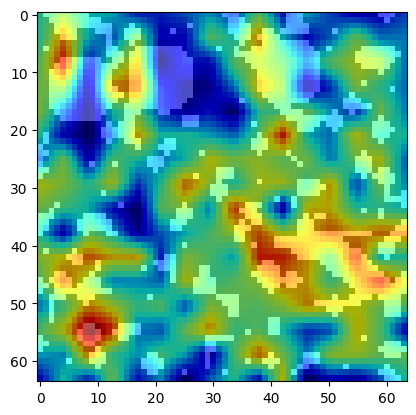

In [ ]:
from tf_keras_vis.scorecam import Scorecam
#genrate scorecam heatmap
scoreCam = Scorecam(model)

sC = scoreCam(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap = 'gray')
plt.imshow(sC, cmap = 'jet', alpha = 0.7)

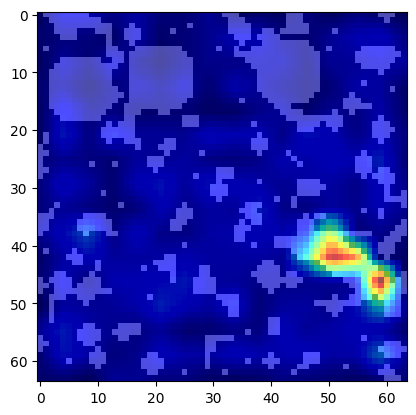

In [ ]:
from tf_keras_vis.layercam import Layercam

lC = Layercam(model, model_modifier=ReplaceToLinear(), clone=True)
lC_img = lC(CategoricalScore(0), img).squeeze()

plt.imshow(img, cmap='gray')
plt.imshow(lC_img, cmap ='jet', alpha = 0.7)

#**Generate gradcams and store**

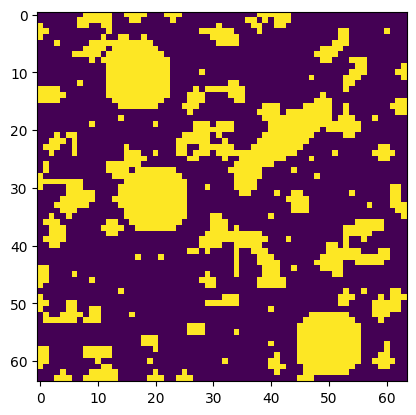

In [ ]:
plt.imshow(path_img)

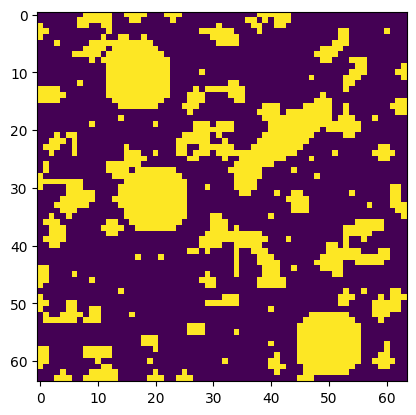

In [ ]:
#Select the image
#Load images to visualize the gradcam
img=path_img #X_test[8] # 0 healthy, 1- healthy,8-Pathological
#img=healthy_img
#img=healthy2_img
plt.imshow(img)

In [ ]:
weight_dir='/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/UMAP_epochs'
# Define the directory to save the Grad-CAM results
gradcam_dir = '/content/drive/MyDrive/MY_Learnings/UPC-CNN_Evolution/Gradcam/1_pathological'
i=1
for filename in os.listdir(weights_dir):
    # Load the weights
    weights_path = os.path.join(weights_dir, filename)
    model.load_weights(weights_path)
    #generate heatmap with keras implmentation of gradcam
    heatmap = explainabilityModels.make_gradcam_heatmap(img, model)
    plt.imshow(img, cmap = 'gray')
    plt.imshow(heatmap, alpha = 0.7, cmap='jet')
    plt.axis('off')
    plt.title(f"Gradcam - Epoch {i}")

     # Save the UMAP visualization
    grad_filepath =  os.path.join(
        gradcam_dir,  f"Gradcam_{i}.png")
    plt.savefig( grad_filepath)
    # Clear the plot for the next epoch
    plt.clf()
    i=i+1


<Figure size 640x480 with 0 Axes>